# HPA Usage
Pesquisa por código no Github, buscando por arquivos que contenham definições de HPA (HorizontalPodAutoscaler).

Filtra por repositórios com alguma relevância (número de estrelas) e apresenta estatísticas.

Os arquivos encontrados após o filtro são salvos no diretório `search_results`.

## Preparando o ambiente

In [1]:
import os
import glob
import time
import re
import json
import requests
import yaml
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo

from joblib import Parallel, delayed
from dotenv import dotenv_values
from ghapi.core import GhApi, HTTP422UnprocessableEntityError, HTTP404NotFoundError, HTTP403ForbiddenError
import fastcore
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('bmh')

import utils

In [4]:
config = {
  **os.environ,
  **dotenv_values(".env")
}
github = GhApi(token=config['GITHUB_TOKEN'])

In [60]:
gh_limit = github.rate_limit.get()

print(int(datetime.timestamp(datetime.now())), datetime.now().replace(microsecond=0))
print(gh_limit['resources']['core']['reset'], datetime.fromtimestamp(gh_limit['resources']['core']['reset']))
display(gh_limit['resources'])

1742677284 2025-03-22 18:01:24
1742680884 2025-03-22 19:01:24


```json
{ 'actions_runner_registration': { 'limit': 10000,
                                   'remaining': 10000,
                                   'reset': 1742680884,
                                   'used': 0},
  'audit_log': { 'limit': 1750,
                 'remaining': 1750,
                 'reset': 1742680884,
                 'used': 0},
  'audit_log_streaming': { 'limit': 15,
                           'remaining': 15,
                           'reset': 1742680884,
                           'used': 0},
  'code_scanning_autofix': { 'limit': 10,
                             'remaining': 10,
                             'reset': 1742677344,
                             'used': 0},
  'code_scanning_upload': { 'limit': 1000,
                            'remaining': 1000,
                            'reset': 1742680884,
                            'used': 0},
  'code_search': {'limit': 10, 'remaining': 10, 'reset': 1742677344, 'used': 0},
  'core': {'limit': 5000, 'remaining': 5000, 'reset': 1742680884, 'used': 0},
  'dependency_snapshots': { 'limit': 100,
                            'remaining': 100,
                            'reset': 1742677344,
                            'used': 0},
  'graphql': {'limit': 5000, 'remaining': 5000, 'reset': 1742680884, 'used': 0},
  'integration_manifest': { 'limit': 5000,
                            'remaining': 5000,
                            'reset': 1742680884,
                            'used': 0},
  'scim': {'limit': 15000, 'remaining': 15000, 'reset': 1742680884, 'used': 0},
  'search': {'limit': 30, 'remaining': 30, 'reset': 1742677344, 'used': 0},
  'source_import': { 'limit': 100,
                     'remaining': 100,
                     'reset': 1742677344,
                     'used': 0}}
```

## Definindo Funções Principais

In [61]:
def wait_for_reset(resource):
  limit = github.rate_limit.get()['resources'][resource]
  reset_time = datetime.fromtimestamp(limit['reset'])
  now = datetime.today().replace(microsecond=0)
  if limit['remaining'] <= 1:
    sleep_duration = reset_time - now
    if sleep_duration.total_seconds() < 0:
      sleep_duration = timedelta(seconds=60)
    print(f"Waiting for {sleep_duration.total_seconds()} seconds")
    time.sleep(sleep_duration.total_seconds())

def search_code_hpa():
  """
  Realiza a pesquisa por arquivos de código contendo definição de um HPA ("kind: HorizontalPodAutoscaler")
  
  Por limitação da API, a cada pesquisa, um máximo de 1000 itens será retornado.
  """
  result_items = []
  page = 1

  # search_result acumula cada página da pesquisa
  search_result = None

  # Carrega as páginas da pesquisa
  while search_result is None or len(result_items) < search_result['total_count']:
    wait_for_reset('code_search')
    print(f"Carregando página {page}")
    time.sleep(1)
    try:
      search_result = github.search.code(q='"kind: HorizontalPodAutoscaler" language:yaml', per_page=100, page=page)
      result_items.extend(search_result['items'])
      page += 1
    except HTTP422UnprocessableEntityError as e:
      return result_items


def get_repo_details(row):
  wait_for_reset('core')
  name_parts = re.split(r'/', row['repo_name'])
  
  try:
    repo_details = github.repos.get(owner=name_parts[0], repo=name_parts[1])
  except HTTP403ForbiddenError:
    print("Limit reached")
    wait_for_reset('core')
    repo_details = github.repos.get(owner=name_parts[0], repo=name_parts[1])
  except (HTTP404NotFoundError, fastcore.net.HTTP404NotFoundError):
    return {
      'stargazers_count': None,
      'created_at': None,
      'pushed_at': None
    }
  
  return {
    'stargazers_count': repo_details['stargazers_count'],
    'created_at': repo_details['created_at'],
    'pushed_at': repo_details['pushed_at']
  }

def get_file_commit(row):
  wait_for_reset('core')
  name_parts = re.split(r'/', row['repo_name'])

  try:
    commits = github.repos.list_commits(owner=name_parts[0], repo=name_parts[1], path=row['file_path'], per_page=1)
  except HTTP403ForbiddenError:
    print("Limit reached")
    wait_for_reset('core')
    commits = github.repos.list_commits(owner=name_parts[0], repo=name_parts[1], path=row['file_path'], per_page=1)
  except (HTTP404NotFoundError, fastcore.net.HTTP404NotFoundError):
    return {
      'file_committed_at': None,
      'message': None
    }

  if len(commits) == 0:
    return {
      'file_committed_at': None,
      'message': None
    }
  
  return {
      'file_committed_at': commits[0]['commit']['author']['date'],
      'message': commits[0]['commit']['message']
    }


def extract_hpa(yaml_content):
  hpa_list = []
  for doc in yaml_content:
    if isinstance(doc, dict) and doc.get('kind') == "HorizontalPodAutoscaler":
      hpa_list.append(doc)
  return hpa_list


def download_hpa_spec(item):
  if not os.path.isdir('search_results'):
    os.mkdir('search_results')

  print(f"Downloading {item['url']}")
  response = requests.get(item['url'])
  if response.status_code == 200:

    # Remove marcações de template Helm
    clean_text = re.sub(r'{{-.*?}}', '', response.text)
    clean_text = re.sub(r'{{.*?}}', 'helm_command', clean_text)

    yaml_content = list(yaml.safe_load_all(clean_text))
    hpa_content = extract_hpa(yaml_content)
    if hpa_content is None:
      return

    target_path = os.path.join("search_results", item['repo_name'], item['file_path'])
    target_dir = os.path.dirname(target_path)
    os.makedirs(target_dir, exist_ok=True)
    
    with open(target_path, 'w') as file:
      file.write(yaml.dump_all(hpa_content))
  else:
    print(f"Loading {url} returned {response.status_code}")


def download_file(url, repo_name, file_path):
  if not os.path.isdir('search_results'):
    os.mkdir('search_results')
  
  response = requests.get(url.replace('/blob/', '/raw/'))
  if response.status_code == 200:
    target_path = os.path.join("search_results", repo_name, file_path)
    target_dir = os.path.dirname(target_path)
    os.makedirs(target_dir, exist_ok=True)
    with open(target_path, 'w') as file:
      file.write(response.text)
  else:
    print(f'Loading {url} returned {response.status_code}')
    

# Realiza a Pesquisa

In [7]:
search_items = []
result_items = search_code_hpa()
for item in result_items:
  search_items.append({
    'repo_name': item['repository']['full_name'],
    'file_path': item['path'],
    'url': item['html_url']
  })


Waiting for code_search until 2025-03-22 10:26:39
Carregando página 1
Waiting for code_search until 2025-03-22 10:26:41
Carregando página 2
Waiting for code_search until 2025-03-22 10:26:41
Carregando página 3
Waiting for code_search until 2025-03-22 10:26:41
Carregando página 4
Waiting for code_search until 2025-03-22 10:26:41
Carregando página 5
Waiting for code_search until 2025-03-22 10:26:41
Carregando página 6
Waiting for code_search until 2025-03-22 10:26:41
Carregando página 7
Waiting for code_search until 2025-03-22 10:26:41
Carregando página 8
Waiting for code_search until 2025-03-22 10:26:41
Carregando página 9
Waiting for code_search until 2025-03-22 10:26:41
Waiting for 38.0 seconds
Carregando página 10
Waiting for code_search until 2025-03-22 10:27:43
Carregando página 11


In [8]:
items = pd.DataFrame(search_items)

display(items)
print(f"Encontrados {items.shape[0]} arquivos em {len(items['repo_name'].unique())} repositórios")


,repo_name,file_path,url
0,chronolaw/k8s_study,ch4/hpa.yml,https://github.com/chronolaw/k8s_study/blob/1e...
1,krestomatio/moodle-operator,watches.yaml,https://github.com/krestomatio/moodle-operator...
2,bhaveshittadwar/live-stream-kubernetes,hpa.yaml,https://github.com/bhaveshittadwar/live-stream...
3,kaitoz11/Ansible-K8s,k8s/HPA.yaml,https://github.com/kaitoz11/Ansible-K8s/blob/6...
4,moleculerjs/docker-demo,k8s.yaml,https://github.com/moleculerjs/docker-demo/blo...
...,...,...,...
995,solo-io/service-mesh-for-less-blog,tiered-app/1-namespace-app/ambient/waypoints/h...,https://github.com/solo-io/service-mesh-for-le...
996,kuoss/kubeyaml,yamls/knative/horizontalpodautoscaler_istio-te...,https://github.com/kuoss/kubeyaml/blob/03838f6...
997,18F/identity-loadtest,coredns.yaml,https://github.com/18F/identity-loadtest/blob/...
998,AlejandrVilla/cloud-project,k8s/hpa/hpa-server.yaml,https://github.com/AlejandrVilla/cloud-project...


Encontrados 1000 arquivos em 910 repositórios


## Salva Fase 1 da Pesquisa

In [9]:
utils.save_results(items)

## Carrega todas as Pesquisas Anteriores

In [10]:
items = utils.load_results()

print(f"Encontrados {items.shape[0]} arquivos em {len(items['repo_name'].unique())} repositórios")

Encontrados 5294 arquivos em 3764 repositórios


## Dados adicionais
### Número de Estrelas

In [13]:
# Usando Parallel para buscar utilizando jobs em paralelo

repos_details = Parallel(n_jobs=32)(
  delayed(get_repo_details)(row) for _, row in items.iterrows()
)

display(repos_details)


Waiting for 3458.0 seconds
Waiting for 3458.0 seconds
Limit reached
Waiting for 3458.0 seconds
Limit reached
Limit reached
Limit reached
Limit reached
Limit reached
Limit reached
Limit reached
Limit reached
Limit reached
Waiting for 3458.0 seconds
Limit reached
Limit reached
Limit reached
Waiting for 3458.0 seconds
Limit reached
Limit reached
Limit reached
Waiting for 3458.0 seconds
Waiting for 3458.0 seconds
Waiting for 3458.0 seconds
Waiting for 3458.0 seconds
Waiting for 3458.0 seconds
Waiting for 3458.0 seconds
Waiting for 3458.0 seconds
Waiting for 3458.0 seconds
Waiting for 3458.0 seconds
Waiting for 3458.0 seconds
Waiting for 3458.0 seconds
Waiting for 3458.0 seconds
Waiting for 3458.0 seconds
Waiting for 3458.0 seconds
Waiting for 3458.0 seconds
Waiting for 3458.0 seconds
Waiting for 3458.0 seconds
Waiting for 3458.0 seconds
Waiting for 3458.0 seconds
Waiting for 3458.0 seconds
Waiting for 3458.0 seconds
Waiting for 3458.0 seconds
Waiting for 3458.0 seconds
Waiting for 3458.0 s

[{'stargazers_count': 0,
  'created_at': '2023-11-28T17:34:39Z',
  'pushed_at': '2024-01-15T09:15:33Z'},
 {'stargazers_count': 2,
  'created_at': '2022-05-02T18:37:39Z',
  'pushed_at': '2023-08-01T07:52:38Z'},
 {'stargazers_count': 4,
  'created_at': '2023-04-17T06:54:36Z',
  'pushed_at': '2025-03-21T14:11:26Z'},
 {'stargazers_count': 0,
  'created_at': '2023-08-03T03:34:49Z',
  'pushed_at': '2023-08-03T05:39:07Z'},
 {'stargazers_count': 0,
  'created_at': '2022-12-21T08:50:49Z',
  'pushed_at': '2023-01-21T16:25:12Z'},
 {'stargazers_count': 1,
  'created_at': '2024-06-15T05:01:30Z',
  'pushed_at': '2024-06-15T13:25:39Z'},
 {'stargazers_count': 0,
  'created_at': '2020-12-17T13:12:06Z',
  'pushed_at': '2021-07-06T08:58:38Z'},
 {'stargazers_count': 25,
  'created_at': '2016-05-09T21:23:58Z',
  'pushed_at': '2025-03-21T23:50:59Z'},
 {'stargazers_count': 25,
  'created_at': '2016-05-09T21:23:58Z',
  'pushed_at': '2025-03-21T23:50:59Z'},
 {'stargazers_count': 25,
  'created_at': '2016-05-09

In [14]:
df_details = pd.DataFrame(repos_details)
display(df_details.info())

display(df_details[df_details['stargazers_count'].isna()])



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5294 entries, 0 to 5293
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   stargazers_count  5257 non-null   float64
 1   created_at        5257 non-null   object 
 2   pushed_at         5257 non-null   object 
dtypes: float64(1), object(2)
memory usage: 124.2+ KB


None

,stargazers_count,created_at,pushed_at
84,NaN,None,None
146,NaN,None,None
147,NaN,None,None
397,NaN,None,None
696,NaN,None,None
1138,NaN,None,None
1180,NaN,None,None
1271,NaN,None,None
1391,NaN,None,None
1392,NaN,None,None


### Commit do arquivo

In [25]:
wait_for_reset('core')

# paths_committed_at = Parallel(n_jobs=16)(
#   delayed(get_file_commit)(row) for _, row in items.iterrows()
# )

paths_committed_at = [get_file_commit(item[1]) for item in items.iterrows()]


In [26]:
df_committed_at = pd.DataFrame(paths_committed_at)
display(df_committed_at.info())

display(df_committed_at[df_committed_at['message'].isna()])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5294 entries, 0 to 5293
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   file_committed_at  5249 non-null   object
 1   message            5249 non-null   object
dtypes: object(2)
memory usage: 82.8+ KB


None

,file_committed_at,message
84,None,None
146,None,None
147,None,None
397,None,None
544,None,None
696,None,None
831,None,None
1044,None,None
1138,None,None
1180,None,None


In [29]:
items_details = items.join([df_details, df_committed_at])

display(items_details)

# Há alguns itens que representam repositórios que não existem mais (HTTP404NotFoundError)
display(items_details[items_details['stargazers_count'].isna()])

,repo_name,file_path,url,stargazers_count,created_at,pushed_at,file_committed_at,message
0,01-edu/orchestrator,manifests/inventory-app.yaml,https://github.com/01-edu/orchestrator/blob/87...,0.0,2023-11-28T17:34:39Z,2024-01-15T09:15:33Z,2024-01-09T14:19:25Z,feat(secrets): move secrets to kustomization.yaml
1,0GiS0/tour-of-heroes-gitops-demos,helm/tour-of-heroes-chart/charts/api/templates...,https://github.com/0GiS0/tour-of-heroes-gitops...,2.0,2022-05-02T18:37:39Z,2023-08-01T07:52:38Z,2022-05-03T06:56:57Z,Añadidas las plantillas en diferentes tecnologías
2,0hlov3/charts,charts/element-web/templates/hpa.yaml,https://github.com/0hlov3/charts/blob/daca391f...,4.0,2023-04-17T06:54:36Z,2025-03-21T14:11:26Z,2023-04-26T19:25:23Z,Migrates Element Chart - Changes some Ingress ...
3,0nebody/charts,stable/benth/templates/hpa.yaml,https://github.com/0nebody/charts/blob/1ed4ad1...,0.0,2023-08-03T03:34:49Z,2023-08-03T05:39:07Z,2023-08-03T04:47:13Z,add benth chart
4,0xhappyboy/react-template,market-template-1/hokusai/staging.yml,https://github.com/0xhappyboy/react-template/b...,0.0,2022-12-21T08:50:49Z,2023-01-21T16:25:12Z,2023-01-21T16:25:05Z,update : update
...,...,...,...,...,...,...,...,...
5289,zsmn/k8scd,k8s/config/istio/istio-ingress.yaml,https://github.com/zsmn/k8scd/blob/8eb23cf5c1f...,1.0,2024-05-01T12:56:19Z,2025-02-23T15:58:40Z,2024-05-01T13:19:22Z,feat: adding trainticket application
5290,zsmn/k8scd,k8s/config/istio/istio-ingress.yaml,https://github.com/zsmn/k8scd/blob/7830475ad18...,1.0,2024-05-01T12:56:19Z,2025-02-23T15:58:40Z,2024-05-01T13:19:22Z,feat: adding trainticket application
5291,zuc/helm-charts,charts/outline/templates/hpa.yaml,https://github.com/zuc/helm-charts/blob/d28af2...,1.0,2020-06-22T15:09:56Z,2021-05-14T19:57:31Z,2020-06-23T10:25:30Z,test
5292,zuisong/vertx-server-push,k8s.yml,https://github.com/zuisong/vertx-server-push/b...,3.0,2021-03-08T07:59:57Z,2025-03-10T06:37:47Z,2024-01-30T07:41:10Z,use maven build native image


,repo_name,file_path,url,stargazers_count,created_at,pushed_at,file_committed_at,message
84,Aibol51/stock,deploy/k8s/core-rpc.yaml,https://github.com/Aibol51/stock/blob/4c2d9fe6...,NaN,None,None,None,None
146,AtefMlaouhi/argo-cd,quantalys-axa-banque/quantalys-axb-frontend-we...,https://github.com/AtefMlaouhi/argo-cd/blob/e0...,NaN,None,None,None,None
147,AtefMlaouhi/argo-cd,quantalys-policy-act/quantalys-user-proxy-api/...,https://github.com/AtefMlaouhi/argo-cd/blob/e0...,NaN,None,None,None,None
397,EduX-AI/PhD,deployment/helm/templates/background-hpa.yaml,https://github.com/EduX-AI/PhD/blob/9294f97b13...,NaN,None,None,None,None
696,KhusravNazarov/K8S,sessions/handsOn/deployment.yaml,https://github.com/KhusravNazarov/K8S/blob/0fe...,NaN,None,None,None,None
1138,SergK/demo-fastapi,deploy-templates/templates/hpa.yaml,https://github.com/SergK/demo-fastapi/blob/8cd...,NaN,None,None,None,None
1180,SolomonAIEngineering/core-enterprise,charts/core-enterprise-production/templates/wo...,https://github.com/SolomonAIEngineering/core-e...,NaN,None,None,None,None
1271,ThaynaraDaSilva/ez-fastfood-order-ms,k8s/api-hpa.yaml,https://github.com/ThaynaraDaSilva/ez-fastfood...,NaN,None,None,None,None
1391,ZupIT/horusec-platform,deployments/helm/horusec-platform/templates/ho...,https://github.com/ZupIT/horusec-platform/blob...,NaN,None,None,None,None
1392,ZupIT/horusec-platform,deployments/helm/horusec-platform/templates/ho...,https://github.com/ZupIT/horusec-platform/blob...,NaN,None,None,None,None


In [31]:
# Removendo estes itens
items_details.dropna(subset=['stargazers_count'], inplace=True, ignore_index=True)

# Salva DataFrame completo em um CSV
items_details.to_csv(f"partial_results/{datetime.now().replace(microsecond=0).isoformat()}-phase2.csv", index=False)

In [32]:
items_details = utils.load_phase2_results()

print(f"{items_details['repo_name'].unique().shape[0]} repositórios únicos")

items_details['created_at'] = pd.to_datetime(items_details['created_at'])
items_details['pushed_at'] = pd.to_datetime(items_details['pushed_at'])
display(items_details)

3737 repositórios únicos


,repo_name,file_path,url,stargazers_count,created_at,pushed_at,file_committed_at,message
0,01-edu/orchestrator,manifests/inventory-app.yaml,https://github.com/01-edu/orchestrator/blob/87...,0.0,2023-11-28 17:34:39+00:00,2024-01-15 09:15:33+00:00,2024-01-09T14:19:25Z,feat(secrets): move secrets to kustomization.yaml
1,0GiS0/tour-of-heroes-gitops-demos,helm/tour-of-heroes-chart/charts/api/templates...,https://github.com/0GiS0/tour-of-heroes-gitops...,2.0,2022-05-02 18:37:39+00:00,2023-08-01 07:52:38+00:00,2022-05-03T06:56:57Z,Añadidas las plantillas en diferentes tecnologías
2,0hlov3/charts,charts/element-web/templates/hpa.yaml,https://github.com/0hlov3/charts/blob/daca391f...,4.0,2023-04-17 06:54:36+00:00,2025-03-21 14:11:26+00:00,2023-04-26T19:25:23Z,Migrates Element Chart - Changes some Ingress ...
3,0nebody/charts,stable/benth/templates/hpa.yaml,https://github.com/0nebody/charts/blob/1ed4ad1...,0.0,2023-08-03 03:34:49+00:00,2023-08-03 05:39:07+00:00,2023-08-03T04:47:13Z,add benth chart
4,0xhappyboy/react-template,market-template-1/hokusai/staging.yml,https://github.com/0xhappyboy/react-template/b...,0.0,2022-12-21 08:50:49+00:00,2023-01-21 16:25:12+00:00,2023-01-21T16:25:05Z,update : update
...,...,...,...,...,...,...,...,...
5252,zsmn/k8scd,k8s/config/istio/istio-ingress.yaml,https://github.com/zsmn/k8scd/blob/8eb23cf5c1f...,1.0,2024-05-01 12:56:19+00:00,2025-02-23 15:58:40+00:00,2024-05-01T13:19:22Z,feat: adding trainticket application
5253,zsmn/k8scd,k8s/config/istio/istio-ingress.yaml,https://github.com/zsmn/k8scd/blob/7830475ad18...,1.0,2024-05-01 12:56:19+00:00,2025-02-23 15:58:40+00:00,2024-05-01T13:19:22Z,feat: adding trainticket application
5254,zuc/helm-charts,charts/outline/templates/hpa.yaml,https://github.com/zuc/helm-charts/blob/d28af2...,1.0,2020-06-22 15:09:56+00:00,2021-05-14 19:57:31+00:00,2020-06-23T10:25:30Z,test
5255,zuisong/vertx-server-push,k8s.yml,https://github.com/zuisong/vertx-server-push/b...,3.0,2021-03-08 07:59:57+00:00,2025-03-10 06:37:47+00:00,2024-01-30T07:41:10Z,use maven build native image


In [41]:
print("Todos os resultados")
print(items_details['stargazers_count'].describe())

min_stars = 1
print(f"\nMínimo de {min_stars} estrelas")
filter_min_stars = items_details[items_details['stargazers_count'] > min_stars]
print(filter_min_stars['stargazers_count'].describe())

print("\nPercentil > 0.9 estrelas")
filter_outliers_items = items_details[items_details['stargazers_count'] >= items_details['stargazers_count'].quantile(0.90)]
print(filter_outliers_items['stargazers_count'].describe())


Todos os resultados
count     5257.000000
mean       194.996386
std       1473.446380
min          0.000000
25%          0.000000
50%          0.000000
75%          4.000000
max      29619.000000
Name: stargazers_count, dtype: float64

Mínimo de 1 estrelas
count     1733.000000
mean       591.186959
std       2520.723684
min          2.000000
25%          4.000000
50%         14.000000
75%         90.000000
max      29619.000000
Name: stargazers_count, dtype: float64

Percentil > 0.9 estrelas
count      591.000000
mean      1712.548223
std       4091.600260
min         53.000000
25%         85.000000
50%        171.000000
75%        807.500000
max      29619.000000
Name: stargazers_count, dtype: float64


In [42]:
print(f"{filter_min_stars['repo_name'].unique().shape[0]} repositórios únicos")

931 repositórios únicos


# Analisando número de estrelas

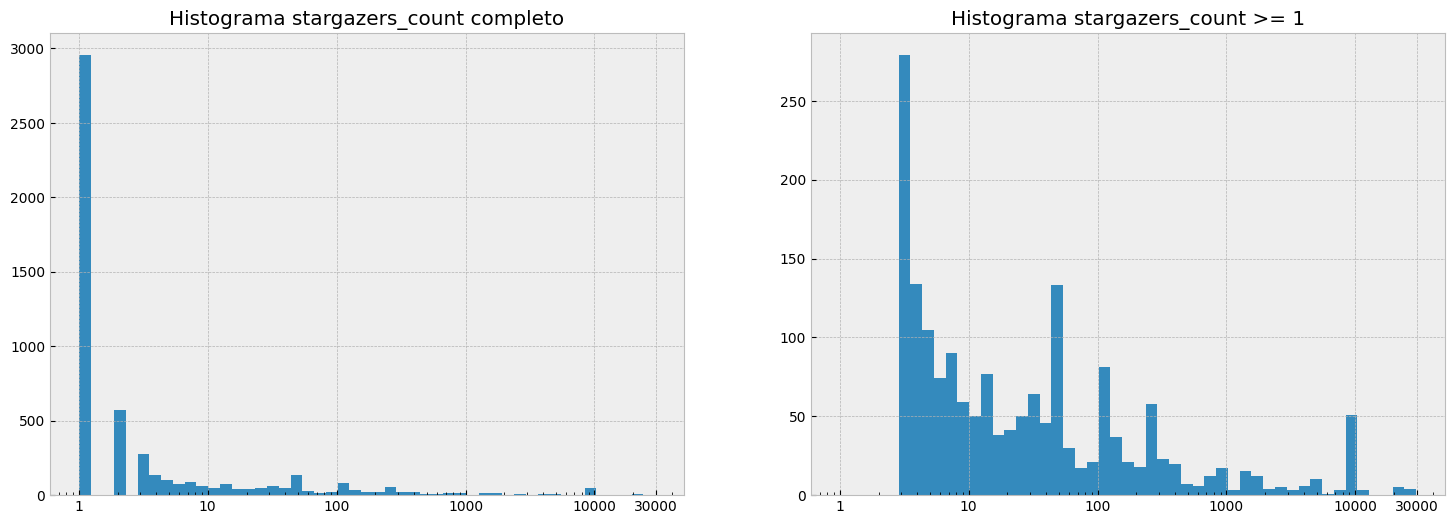

In [43]:
plt.style.use('bmh')
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

data_full = items_details['stargazers_count']
data_filter = filter_min_stars['stargazers_count']

bins_full = np.logspace(0, np.log10(data_full.max() + 1), 50)
bins_filter = np.logspace(0, np.log10(data_filter.max() + 1), 50)

ticks = [1, 10, 100, 1000, 10000, 30000]

axes[0].hist(data_full + 1, bins=bins_full)
axes[0].set_xscale('log')
axes[0].set_xticks(ticks, ticks)
axes[0].set_title("Histograma stargazers_count completo")

axes[1].hist(data_filter + 1, bins=bins_filter)
axes[1].set_xscale('log')
axes[1].set_xticks(ticks, ticks)
axes[1].set_title(f"Histograma stargazers_count >= {min_stars}")

plt.show()

# Analisando created_at e pushed_at

In [44]:
created_at = pd.to_datetime(items_details['created_at'])
pushed_at = pd.to_datetime(items_details['pushed_at'])

print(f"Repositório criado a mais tempo:\t{created_at.min()}\n\
Repositório criado a menos tempo:\t{created_at.max()}")

print(f"Repositório atualizado a mais tempo:\t{pushed_at.min()}\n\
Repositório atualizado a menos tempo:\t{pushed_at.max()}")

Repositório criado a mais tempo:	2011-10-27 05:58:15+00:00
Repositório criado a menos tempo:	2025-03-18 00:12:08+00:00
Repositório atualizado a mais tempo:	2015-12-01 23:05:53+00:00
Repositório atualizado a menos tempo:	2025-03-22 14:05:49+00:00


In [45]:
items_details['life_span'] = items_details['pushed_at'] - items_details['created_at']

display(items_details[items_details['life_span']==items_details['life_span'].min()])

display(items_details['life_span'].describe())

min_days = 180
print(f"\nMínimo de {min_days} dias")
filter_min_days = items_details[items_details['life_span'].dt.days > min_days]
print(filter_min_days['life_span'].describe())

print("\nPercentil > 0.9 mais longevos")
filter_outliers_life_span = items_details[items_details['life_span'] >= items_details['life_span'].quantile(0.90)]
print(filter_outliers_life_span['life_span'].describe())

,repo_name,file_path,url,stargazers_count,created_at,pushed_at,file_committed_at,message,life_span
5225,zccfzcc/docker-images,prometheus/production/example-app/example-app-...,https://github.com/zccfzcc/docker-images/blob/...,0.0,2019-09-18 02:54:06+00:00,2019-04-24 09:33:37+00:00,2019-03-08T04:13:49Z,prometheus,-147 days +06:39:31


count                           5257
mean     553 days 06:02:28.534715616
std      755 days 20:42:41.521182536
min              -147 days +06:39:31
25%                 15 days 12:13:50
50%                174 days 03:54:38
75%                852 days 00:15:52
max               4621 days 20:44:22
Name: life_span, dtype: object


Mínimo de 180 dias
count                            2604
mean     1077 days 10:37:49.628264208
std       778 days 19:17:22.447224880
min                 181 days 01:17:53
25%          433 days 20:16:56.250000
50%          861 days 04:34:38.500000
75%                1518 days 23:58:15
max                4621 days 20:44:22
Name: life_span, dtype: object

Percentil > 0.9 mais longevos
count                             528
mean     2310 days 07:36:28.575757600
std       582 days 04:49:57.830747008
min                1723 days 04:01:55
25%         1817 days 01:22:01.250000
50%         2114 days 16:20:07.500000
75%         2708 days 03:17:41.250000
max                4621 days 20:44:22
Name: life_span, dtype: object


In [46]:
display(items_details['pushed_at'].describe())

limit_oldest_pushed_at = (datetime.today() - timedelta(days=360)).replace(hour=0, minute=0, second=0, microsecond=0, tzinfo=ZoneInfo('GMT'))
print(f"\npushed_at mais recentes do que {limit_oldest_pushed_at}")
filter_newer_pushed_at = items_details[items_details['pushed_at'] > limit_oldest_pushed_at]
print(filter_newer_pushed_at['pushed_at'].describe())

print("\nPercentil >= 0.9 mais recentes")
filter_outliers_life_span = items_details[items_details['pushed_at'] >= items_details['pushed_at'].quantile(0.90)]
print(filter_outliers_life_span['pushed_at'].describe())

count                                   5257
mean     2024-02-14 20:50:04.337074432+00:00
min                2015-12-01 23:05:53+00:00
25%                2023-08-23 17:42:07+00:00
50%                2024-09-12 13:00:06+00:00
75%                2025-03-06 17:04:22+00:00
max                2025-03-22 14:05:49+00:00
Name: pushed_at, dtype: object


pushed_at mais recentes do que 2024-03-27 00:00:00+00:00
count                                   3384
mean     2024-12-16 05:11:31.549941248+00:00
min                2024-03-27 14:33:20+00:00
25%      2024-09-27 20:39:57.750000128+00:00
50%         2025-01-25 06:07:50.500000+00:00
75%      2025-03-20 07:08:05.249999872+00:00
max                2025-03-22 14:05:49+00:00
Name: pushed_at, dtype: object

Percentil >= 0.9 mais recentes
count                                    527
mean     2025-03-22 02:59:38.053130752+00:00
min                2025-03-21 18:26:48+00:00
25%                2025-03-22 00:07:00+00:00
50%                2025-03-22 01:19:23+00:00
75%         2025-03-22 06:13:26.500000+00:00
max                2025-03-22 14:05:49+00:00
Name: pushed_at, dtype: object


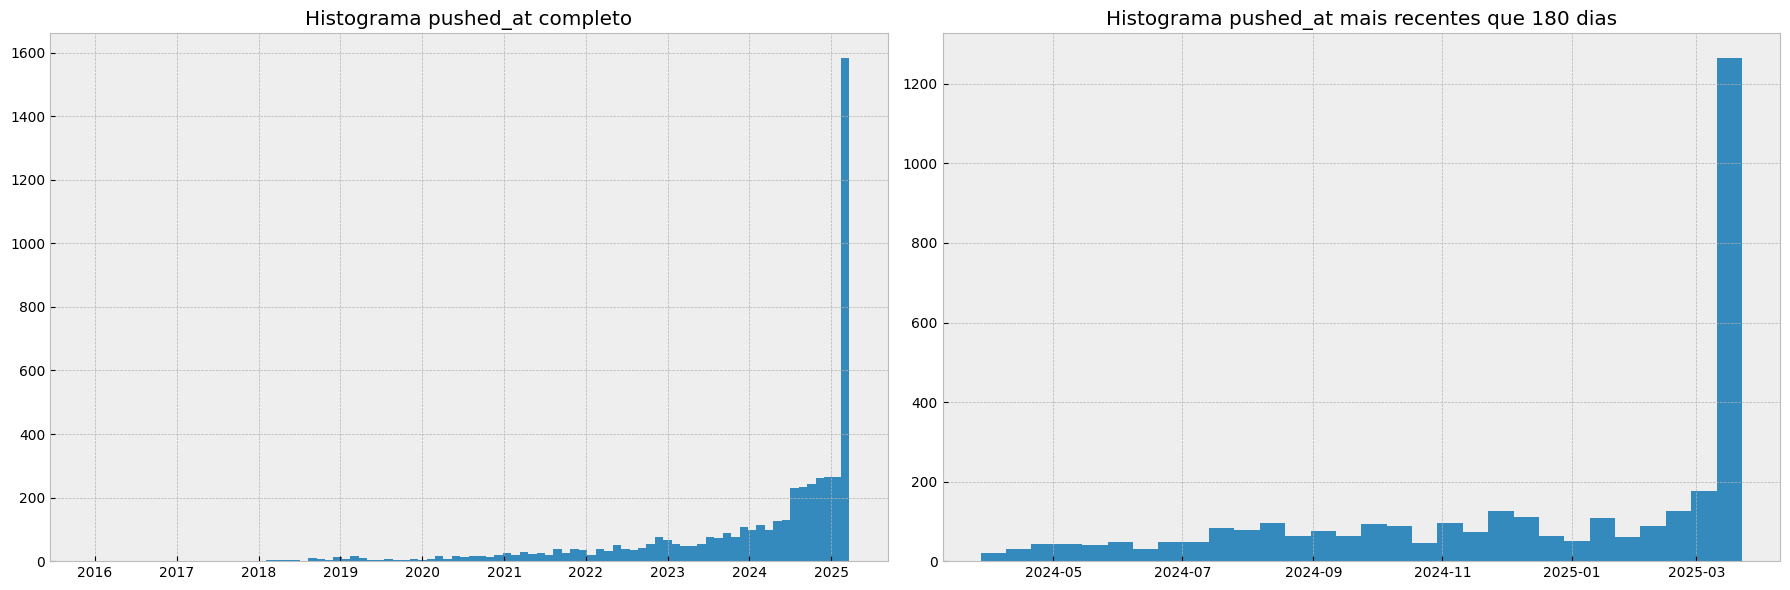

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

data_full = items_details['pushed_at']
data_filter = filter_newer_pushed_at['pushed_at']

# bins_full = np.logspace(0, np.log10(data_full.max() + 1), 50)
# bins_filter = np.logspace(0, np.log10(data_filter.max() + 1), 50)

ticks = [1, 10, 100, 1000, 10000, 30000]

axes[0].hist(data_full, bins=90)
# axes[0].set_xticks(ticks, ticks)
axes[0].set_title("Histograma pushed_at completo")

axes[1].hist(data_filter, bins=30)
# axes[1].set_xticks(ticks, ticks)
axes[1].set_title("Histograma pushed_at mais recentes que 180 dias")

plt.tight_layout()
plt.show()

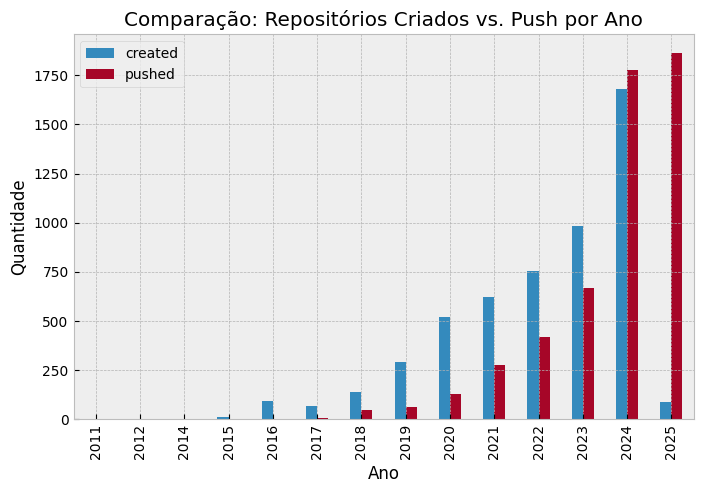

In [48]:
items_details['created_at'] = pd.to_datetime(items_details['created_at'])
items_details['pushed_at'] = pd.to_datetime(items_details['pushed_at'])

items_details['created_year'] = items_details['created_at'].dt.year
items_details['pushed_year'] = items_details['pushed_at'].dt.year

created_year_count = items_details.groupby('created_year')['repo_name'].count()
pushed_year_count = items_details.groupby('pushed_year')['repo_name'].count()

df_anos = pd.DataFrame({
    'created': created_year_count,
    'pushed': pushed_year_count
})

df_anos.plot(kind='bar', figsize=(8,5))
plt.title('Comparação: Repositórios Criados vs. Push por Ano')
plt.xlabel('Ano')
plt.ylabel('Quantidade')
plt.show()


# Filtrando por Número de Estrelas e por Último Commit

In [49]:
filtered_items = items_details[(items_details['stargazers_count'] > min_stars) & (items_details['pushed_at'] > limit_oldest_pushed_at)]

print(filtered_items.info())

display(filtered_items)

<class 'pandas.core.frame.DataFrame'>
Index: 1308 entries, 2 to 5255
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   repo_name          1308 non-null   object             
 1   file_path          1308 non-null   object             
 2   url                1308 non-null   object             
 3   stargazers_count   1308 non-null   float64            
 4   created_at         1308 non-null   datetime64[ns, UTC]
 5   pushed_at          1308 non-null   datetime64[ns, UTC]
 6   file_committed_at  1307 non-null   object             
 7   message            1307 non-null   object             
 8   life_span          1308 non-null   timedelta64[ns]    
 9   created_year       1308 non-null   int32              
 10  pushed_year        1308 non-null   int32              
dtypes: datetime64[ns, UTC](2), float64(1), int32(2), object(5), timedelta64[ns](1)
memory usage: 112.4+ KB
None


,repo_name,file_path,url,stargazers_count,created_at,pushed_at,file_committed_at,message,life_span,created_year,pushed_year
2,0hlov3/charts,charts/element-web/templates/hpa.yaml,https://github.com/0hlov3/charts/blob/daca391f...,4.0,2023-04-17 06:54:36+00:00,2025-03-21 14:11:26+00:00,2023-04-26T19:25:23Z,Migrates Element Chart - Changes some Ingress ...,704 days 07:16:50,2023,2025
7,18F/identity-dashboard,dockerfiles/application.yaml,https://github.com/18F/identity-dashboard/blob...,25.0,2016-05-09 21:23:58+00:00,2025-03-21 23:50:59+00:00,2024-12-17T20:05:37Z,fix reviewapp service providers in dbsetup ste...,3238 days 02:27:01,2016,2025
8,18F/identity-dashboard,dockerfiles/application.yaml,https://github.com/18F/identity-dashboard/blob...,25.0,2016-05-09 21:23:58+00:00,2025-03-21 23:50:59+00:00,2024-12-17T20:05:37Z,fix reviewapp service providers in dbsetup ste...,3238 days 02:27:01,2016,2025
9,18F/identity-dashboard,dockerfiles/application.yaml,https://github.com/18F/identity-dashboard/blob...,25.0,2016-05-09 21:23:58+00:00,2025-03-21 23:50:59+00:00,2024-12-17T20:05:37Z,fix reviewapp service providers in dbsetup ste...,3238 days 02:27:01,2016,2025
10,18F/identity-dashboard,dockerfiles/application.yaml,https://github.com/18F/identity-dashboard/blob...,25.0,2016-05-09 21:23:58+00:00,2025-03-21 23:50:59+00:00,2024-12-17T20:05:37Z,fix reviewapp service providers in dbsetup ste...,3238 days 02:27:01,2016,2025
...,...,...,...,...,...,...,...,...,...,...,...
5238,zhaodangxue/Minik8s,controller/src/HPAController/test/hpa-example....,https://github.com/zhaodangxue/Minik8s/blob/b1...,3.0,2024-07-03 07:37:00+00:00,2024-07-11 14:33:04+00:00,2024-05-25T09:11:43Z,hpacontroller complete,8 days 06:56:04,2024,2024
5239,zhaodangxue/Minik8s,apiobjects/examples/pod/hpa-example.yaml,https://github.com/zhaodangxue/Minik8s/blob/b1...,3.0,2024-07-03 07:37:00+00:00,2024-07-11 14:33:04+00:00,2024-05-30T14:37:31Z,complete get node,8 days 06:56:04,2024,2024
5244,zilliztech/milvus-operator,config/samples/hpa.yaml,https://github.com/zilliztech/milvus-operator/...,69.0,2023-08-08 03:02:18+00:00,2025-03-20 11:12:05+00:00,2024-11-19T09:57:39Z,chart: make webhook optional\n\nSigned-off-by:...,590 days 08:09:47,2023,2025
5247,zjzjzjzj1874/best-practice-go-zero,task/task-k8s.yaml,https://github.com/zjzjzjzj1874/best-practice-...,10.0,2022-06-06 09:46:12+00:00,2025-02-08 06:13:19+00:00,2023-02-23T07:40:16Z,feat✨(swagger): add missing files\n\nSigned-of...,977 days 20:27:07,2022,2025


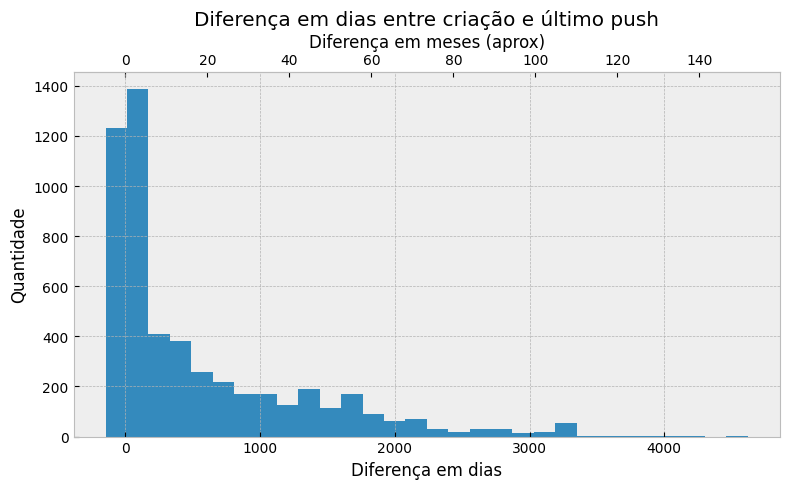

In [50]:
fig, ax = plt.subplots(figsize=(8,5))
n, bins, patches = ax.hist(items_details['life_span'].dt.days, bins=30)
ax.set_xlabel('Diferença em dias')
ax.set_ylabel('Quantidade')

def days_to_months(x):
  return x / 30.4375

def months_to_days(x):
  return x * 30.4375

secax_months = ax.secondary_xaxis('top', functions=(days_to_months, months_to_days))
secax_months.set_xlabel("Diferença em meses (aprox)")

plt.title('Diferença em dias entre criação e último push')
plt.tight_layout()
plt.show()

# Definindo corte de repositórios relevantes

In [51]:
filtered_items = filter_min_stars.sort_values(by=['stargazers_count'])
filtered_items

,repo_name,file_path,url,stargazers_count,created_at,pushed_at,file_committed_at,message
1574,armanfeili/personality-website,Kubernetes/db-deployment.yaml,https://github.com/armanfeili/personality-webs...,2.0,2024-07-04 08:41:00+00:00,2024-08-15 10:24:47+00:00,2024-07-04T08:42:40Z,Initial commit
1570,argoproj-archive/microservices-demo,deploy/kubernetes/autoscaling/catalogue-hsc.yaml,https://github.com/argoproj-archive/microservi...,2.0,2017-08-18 19:28:36+00:00,2017-08-24 20:54:26+00:00,2017-08-18T19:40:14Z,Initial
1566,arafkarsh/k8s-quickstart,colima/Yamls/app/fusion-12-water-product-hpa-g...,https://github.com/arafkarsh/k8s-quickstart/bl...,2.0,2025-01-29 06:21:43+00:00,2025-02-21 03:11:00+00:00,2025-02-18T14:34:23Z,"Kubernetes Canary, A/B Testing, Blue/Green Exa..."
2435,ferama/helm-charts,charts/crauti/templates/hpa.yaml,https://github.com/ferama/helm-charts/blob/86b...,2.0,2022-01-23 07:52:42+00:00,2024-02-21 10:01:11+00:00,2023-03-29T20:36:53Z,crauti 0.1.0
204,CAVEconnectome/CAVEdeployment,kubetemplates/proxy.yml,https://github.com/CAVEconnectome/CAVEdeployme...,2.0,2022-01-10 20:17:20+00:00,2025-03-21 20:20:11+00:00,2022-02-02T23:27:58Z,intitial push
...,...,...,...,...,...,...,...,...
197,Budibase/budibase,charts/budibase/templates/automation-worker-se...,https://github.com/Budibase/budibase/blob/1328...,23692.0,2019-06-07 11:03:41+00:00,2025-03-21 20:08:09+00:00,2024-05-08T14:55:14Z,prevent lack of start/end date from causing UI...
2616,grafana/loki,production/helm/loki/templates/querier/hpa.yaml,https://github.com/grafana/loki/blob/8fd8697b9...,25009.0,2018-04-16 09:22:48+00:00,2025-03-21 22:37:11+00:00,2024-04-08T20:09:40Z,feat!: update helm chart to support distribute...
4923,transloadit/uppy,packages/@uppy/companion/infra/kube/companion/...,https://github.com/transloadit/uppy/blob/ead58...,29619.0,2015-11-16 12:32:33+00:00,2025-03-18 15:42:56+00:00,2023-09-29T09:11:28Z,meta: run Prettier on existing files (#4713)
4924,transloadit/uppy,packages/@uppy/companion/infra/kube/companion/...,https://github.com/transloadit/uppy/blob/4f045...,29619.0,2015-11-16 12:32:33+00:00,2025-03-18 15:42:56+00:00,2023-09-29T09:11:28Z,meta: run Prettier on existing files (#4713)


In [54]:
def prepare_csv(item):
  owner_repo = re.split(pattern=r'/', string=item['repo_name'])
  return pd.Series({
    'owner': owner_repo[0],
    'repo': owner_repo[1],
    'path': item['file_path']
  })

timestamp = datetime.now().replace(microsecond=0).isoformat()
csv_prepared = filter_min_stars.apply(prepare_csv, axis=1)
csv_prepared.to_csv(f"partial_results/{timestamp}-phase3.csv")


In [62]:
urls = filter_min_stars['url'].tolist()
repo_names = filter_min_stars['repo_name'].tolist()
file_paths = filter_min_stars['file_path'].tolist()

Parallel(n_jobs=2)(
  delayed(download_file)(url, repo_name, file_path)
  for url, repo_name, file_path in zip(urls, repo_names, file_paths)
)

# for line in filter_min_stars.iterrows():
#   download_file(line[1]['url'], line[1]['repo_name'], line[1]['file_path'])


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,